In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import warnings

In [189]:
warnings.filterwarnings('ignore')

In [190]:
stocks = ['AAPL', 'GE', '005930.KS']
data = {stock: yf.download(stock, start='2003-01-01', end='2023-01-01') for stock in stocks}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [191]:
def exponential_smoothing(series, alpha):
    model = SimpleExpSmoothing(series).fit(smoothing_level=alpha, optimized=False)
    return model.fittedvalues

In [192]:
def preprocess_data(df, alpha=0.2, horizon=1):
    df['Smoothed_Close'] = exponential_smoothing(df['Close'], alpha)

    # RSI Calculation
    delta = df['Smoothed_Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + 1e-10)  # Add small constant to avoid division by zero
    df['RSI'] = 100 - (100 / (1 + rs))

    # Stochastic Oscillator
    high_14 = df['High'].rolling(window=14).max()
    low_14 = df['Low'].rolling(window=14).min()
    df['Stochastic'] = ((df['Close'] - low_14) / (high_14 - low_14)) * 100

    # Williams %R
    df['Williams %R'] = ((high_14 - df['Close']) / (high_14 - low_14)) * -100

    # MACD (Moving Average Convergence Divergence)
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Rate of Change (ROC)
    df['ROC'] = ((df['Close'] - df['Close'].shift(10)) / df['Close'].shift(10)) * 100

    # On-Balance Volume (OBV)
    df['OBV'] = (np.where(df['Close'] > df['Close'].shift(1), df['Volume'],
                 np.where(df['Close'] < df['Close'].shift(1), -df['Volume'], 0))).cumsum()

    # Target Variable (Up/Down Classification)
    df['Target'] = (df['Smoothed_Close'].shift(-horizon) > df['Smoothed_Close']).astype(int)
    
    return df


processed_data = {stock: preprocess_data(data[stock]) for stock in stocks}

In [193]:
for stock, df in processed_data.items():
    print(f"Stock: {stock}")
    print(f"Class size: {df['Target'].value_counts().sum()}")

Stock: AAPL
Class size: 5035
Stock: GE
Class size: 5035
Stock: 005930.KS
Class size: 4991


In [194]:
def prepare_feature_labels(df):
    X = df[['RSI', 'Stochastic', 'MACD', 'Williams %R', 'ROC', 'OBV']].values
    y = (df['Target'] > 0).astype(int) # Rise = 1, Fall = -1
    return X, y

In [195]:
def time_series_split_tscv(df):
    X, y = prepare_feature_labels(df)  # Extract features and labels
    tscv = TimeSeriesSplit(n_splits=5)

    model = RandomForestClassifier(n_estimators=10, random_state=42)

    auc_scores = []
    accuracy_scores = []
    all_y_test = []
    all_y_pred_proba = []

    for train_index, test_index in tscv.split(X):
        # Split the data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the model
        model.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred_proba)

        accuracy_scores.append(accuracy)
        auc_scores.append(auc_score)

        # Store for ROC curve
        all_y_test.append(y_test)
        all_y_pred_proba.append(y_pred_proba)
    
    # Flatten lists for plotting
    all_y_test = np.concatenate(all_y_test)
    all_y_pred_proba = np.concatenate(all_y_pred_proba)

    metrics = {"Mean Accuracy": np.mean(accuracy), "Mean AUC": np.mean(auc_score)}
    
    return all_y_test, all_y_pred_proba, metrics

In [ ]:
def time_series_train_test_split(df, train_size=0.8):

    X, y = prepare_feature_labels(df) # Extract features and labels

    # Perform train-test split without shuffling
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, stratify=y
    )

    # Train Random Forest model
    model = RandomForestClassifier(n_estimators=10, random_state=42)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    return fpr, tpr, auc_score

In [197]:
def calculate_oob_error(df, horizon, n_trees):
    # Preprocess data for the specific horizon
    df = preprocess_data(df, horizon=horizon)
    X, y = prepare_feature_labels(df)

    # Train Random Forest with OOB score enabled
    model = RandomForestClassifier(n_estimators=n_trees, oob_score=True, random_state=42)
    model.fit(X, y)

    # Calculate OOB error
    oob_error = 1 - model.oob_score_
    return oob_error

In [ ]:
def evaluate_oob_errors(processed_data, horizons, n_trees_list):
    results = []

    for stock, df in processed_data.items():
        for horizon in horizons:
            for n_trees in n_trees_list:
                print(f"Evaluating {stock}: {horizon}-day horizon, {n_trees} trees")
                oob_error = calculate_oob_error(df, horizon, n_trees)

                results.append({
                    "Stock": stock,
                    "Horizon": horizon,
                    "Num_Trees": n_trees,
                    "OOB_Error": oob_error
                })

    return pd.DataFrame(results)

In [199]:
def plot_oob_errors(results_df):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=results_df, x="Num_Trees", y="OOB_Error", hue="Horizon", marker="o")
    plt.title("OOB Error vs. Number of Trees")
    plt.xlabel("Number of Trees")
    plt.ylabel("OOB Error")
    plt.grid()
    plt.legend(title="Trading Period (Days)")
    plt.show()


In [200]:
def plot_all_roc_curves(stock_results):
    for stock, day_results in stock_results.items():
        plt.figure(figsize=(10, 6))
        for days, results in day_results.items():
            y_test = results["y_test"]
            y_pred_proba = results["y_pred_proba"]
            metrics = results["metrics"]
            # Compute ROC curve
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            auc_score = metrics["Mean AUC"]

            # Plot ROC curve
            plt.plot(fpr, tpr, label=f"{days}-day model (AUC={auc_score:.2f})")

        # Plot diagonal line
        plt.plot([0, 1], [0, 1], 'r--')

        plt.title(f"ROC Curves for {stock}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.grid()
        plt.show()

Evaluating stock: AAPL
Evaluating 30-day model for AAPL
AAPL - 30-day model:
Mean Accuracy: 0.4970
Mean AUC: 0.4566
Evaluating 60-day model for AAPL
AAPL - 60-day model:
Mean Accuracy: 0.5471
Mean AUC: 0.5200
Evaluating 90-day model for AAPL
AAPL - 90-day model:
Mean Accuracy: 0.5352
Mean AUC: 0.5978
Evaluating stock: GE
Evaluating 30-day model for GE
GE - 30-day model:
Mean Accuracy: 0.5006
Mean AUC: 0.4842
Evaluating 60-day model for GE
GE - 60-day model:
Mean Accuracy: 0.5161
Mean AUC: 0.5249
Evaluating 90-day model for GE
GE - 90-day model:
Mean Accuracy: 0.3993
Mean AUC: 0.5604
Evaluating stock: 005930.KS
Evaluating 30-day model for 005930.KS
005930.KS - 30-day model:
Mean Accuracy: 0.3935
Mean AUC: 0.3667
Evaluating 60-day model for 005930.KS
005930.KS - 60-day model:
Mean Accuracy: 0.4958
Mean AUC: 0.4812
Evaluating 90-day model for 005930.KS
005930.KS - 90-day model:
Mean Accuracy: 0.4404
Mean AUC: 0.4330


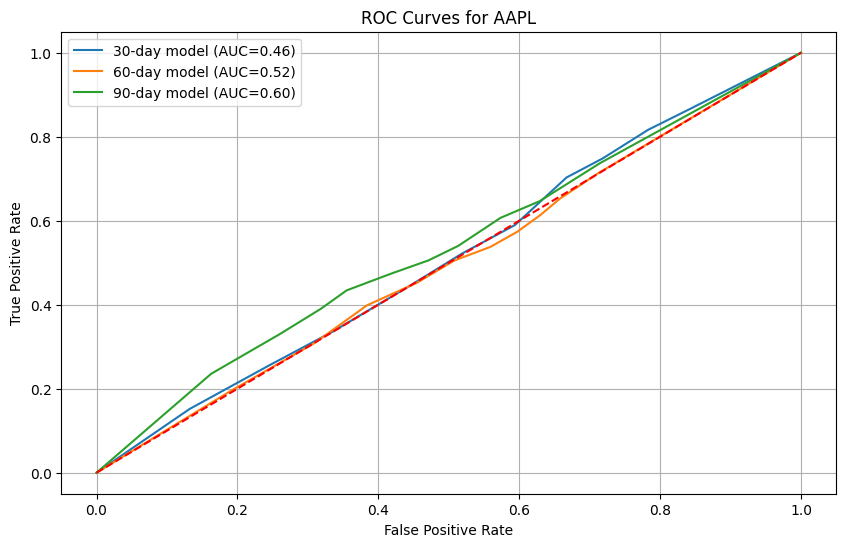

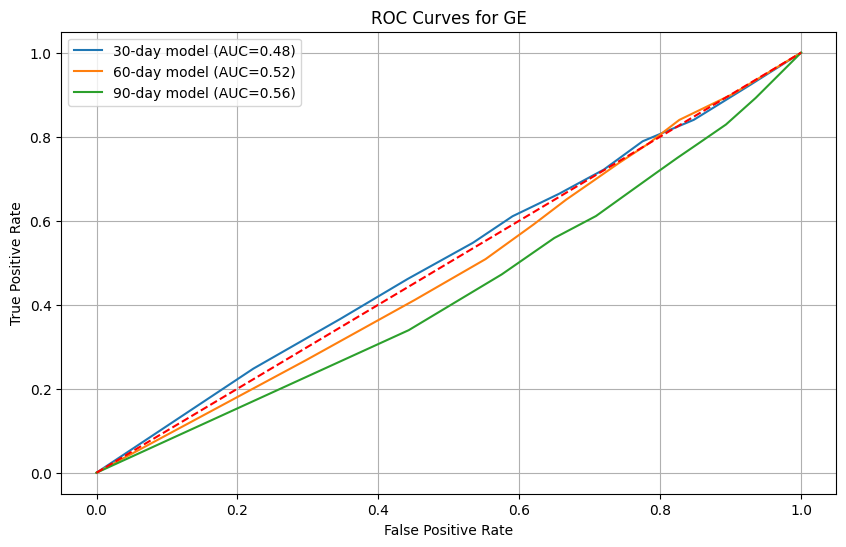

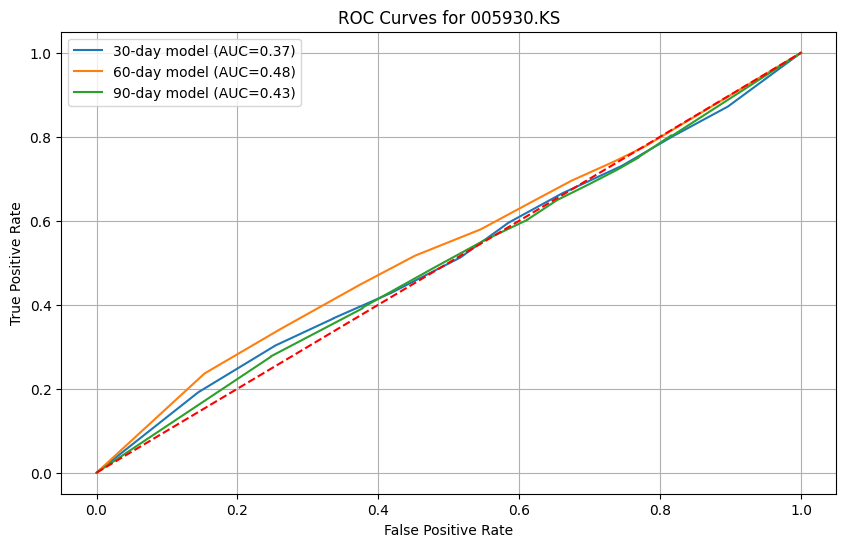

Evaluating AAPL: 30-day horizon, 5 trees
Evaluating AAPL: 30-day horizon, 25 trees
Evaluating AAPL: 30-day horizon, 45 trees
Evaluating AAPL: 30-day horizon, 65 trees
Evaluating AAPL: 60-day horizon, 5 trees
Evaluating AAPL: 60-day horizon, 25 trees
Evaluating AAPL: 60-day horizon, 45 trees
Evaluating AAPL: 60-day horizon, 65 trees
Evaluating AAPL: 90-day horizon, 5 trees
Evaluating AAPL: 90-day horizon, 25 trees
Evaluating AAPL: 90-day horizon, 45 trees
Evaluating AAPL: 90-day horizon, 65 trees
Evaluating GE: 30-day horizon, 5 trees
Evaluating GE: 30-day horizon, 25 trees
Evaluating GE: 30-day horizon, 45 trees
Evaluating GE: 30-day horizon, 65 trees
Evaluating GE: 60-day horizon, 5 trees
Evaluating GE: 60-day horizon, 25 trees
Evaluating GE: 60-day horizon, 45 trees
Evaluating GE: 60-day horizon, 65 trees
Evaluating GE: 90-day horizon, 5 trees
Evaluating GE: 90-day horizon, 25 trees
Evaluating GE: 90-day horizon, 45 trees
Evaluating GE: 90-day horizon, 65 trees
Evaluating 005930.KS: 

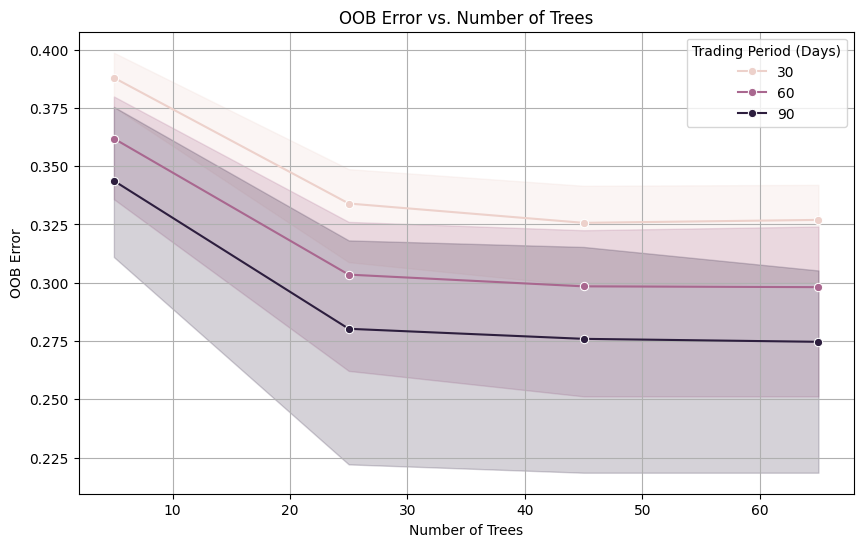

In [201]:
stock_results = {}

for stock, df in processed_data.items():
    print(f"Evaluating stock: {stock}")

    # Dictionary to store ROC data for different day models
    stock_results[stock] = {}

    for days in [30, 60, 90]:  # Day models
        print(f"Evaluating {days}-day model for {stock}")
        
        # Preprocess the DataFrame for the specific day model if needed
        df_day_model = preprocess_data(df, horizon=days)
        
        # Get ROC data
        y_test, y_pred_proba, metrics = time_series_split_tscv(df_day_model)

        # Store results
        stock_results[stock][days] = {"y_test": y_test, "y_pred_proba": y_pred_proba, "metrics": metrics}

        print(f"{stock} - {days}-day model:")
        print(f"Mean Accuracy: {metrics['Mean Accuracy']:.4f}")
        print(f"Mean AUC: {metrics['Mean AUC']:.4f}")
        

plot_all_roc_curves(stock_results)

horizons = [30, 60, 90]
n_trees_list = [5, 25, 45, 65]

oob_results = evaluate_oob_errors(processed_data, horizons, n_trees_list)
print(oob_results)

plot_oob_errors(oob_results)